# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [56]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.utils.data import get_outliers_inliers
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

## 1. Data Cleaning

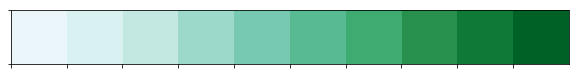

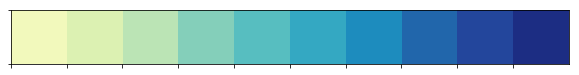

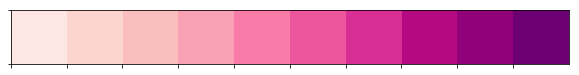

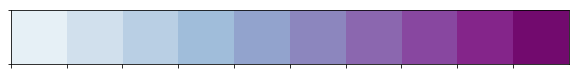

In [57]:
# Create color palettes for seaborn
sns.palplot(sns.color_palette("BuGn", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
RdPu = ['#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']
sns.palplot(sns.color_palette("RdPu", 10))
BuPu = ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b']
sns.palplot(sns.color_palette("BuPu", 10))

In [139]:
df = pd.read_excel('credit_card_default.xls')
df.columns=df.iloc[0]
df=df.drop(0).reset_index(drop=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [140]:
df = df.astype(int)
df=df.drop('ID', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int32
SEX                           30000 non-null int32
EDUCATION                     30000 non-null int32
MARRIAGE                      30000 non-null int32
AGE                           30000 non-null int32
PAY_0                         30000 non-null int32
PAY_2                         30000 non-null int32
PAY_3                         30000 non-null int32
PAY_4                         30000 non-null int32
PAY_5                         30000 non-null int32
PAY_6                         30000 non-null int32
BILL_AMT1                     30000 non-null int32
BILL_AMT2                     30000 non-null int32
BILL_AMT3                     30000 non-null int32
BILL_AMT4                     30000 non-null int32
BILL_AMT5                     30000 non-null int32
BILL_AMT6                     30000 non-null int32
PAY_AMT1                

In [141]:
df.SEX = np.where(df.SEX == 1, 'Male', 'Female')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,Female,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


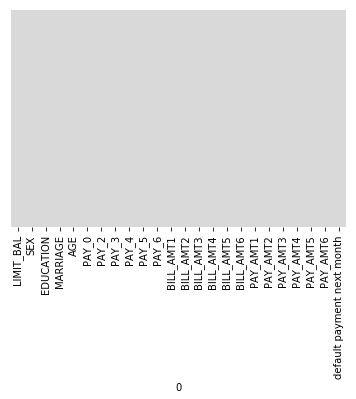

In [24]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='tab20c_r')

In [16]:
df.describe()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. EDA

In [24]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [142]:
ed_todrop = df[(df.EDUCATION>4) | (df.EDUCATION==0)].index
df.drop(ed_todrop, inplace=True)
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      123
Name: EDUCATION, dtype: int64

In [71]:
df.MARRIAGE.value_counts()

2    15806
1    13477
3      318
0       54
Name: MARRIAGE, dtype: int64

In [143]:
mar_todrop = df[df.MARRIAGE ==0].index
df.drop(mar_todrop, inplace=True)
df.MARRIAGE.value_counts()

2    15806
1    13477
3      318
Name: MARRIAGE, dtype: int64

In [39]:
df.PAY_6.value_counts()
# after checking all of these columns half of the data is labeled 0 which relates to nothing in the dictionary. as a result we will drop these columns

 0    16053
-1     5674
-2     4806
 2     2756
 3      183
 4       49
 7       46
 6       19
 5       13
 8        2
Name: PAY_6, dtype: int64

In [144]:
df=df.drop(['PAY_0', 'PAY_2', 'PAY_3','PAY_4','PAY_5', 'PAY_6'], axis=1)
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)

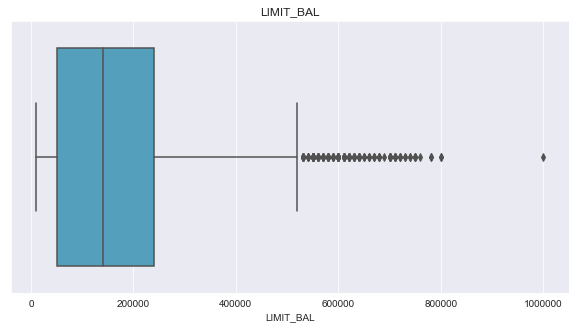

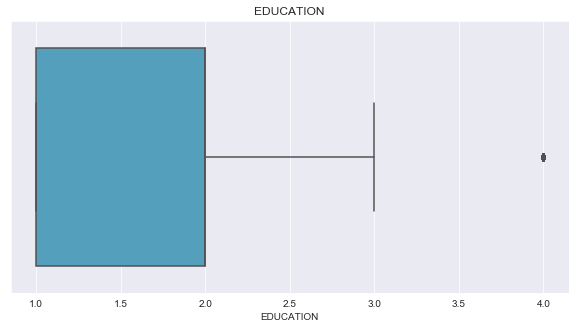

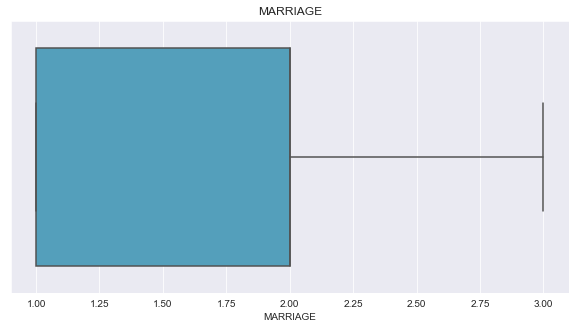

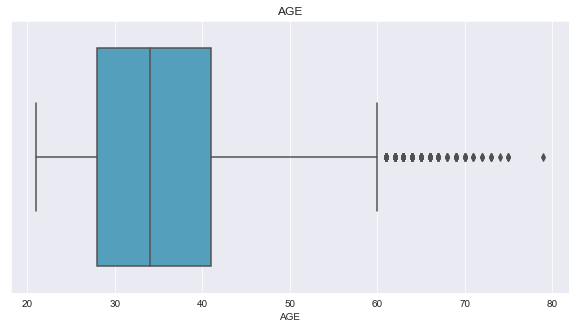

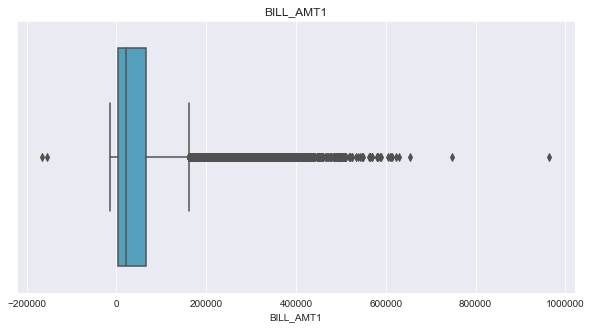

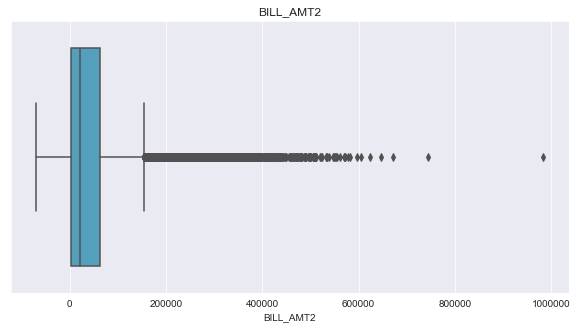

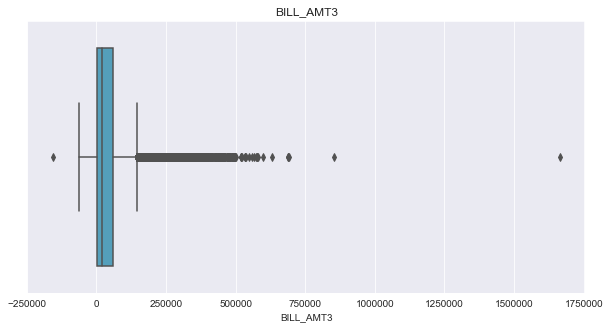

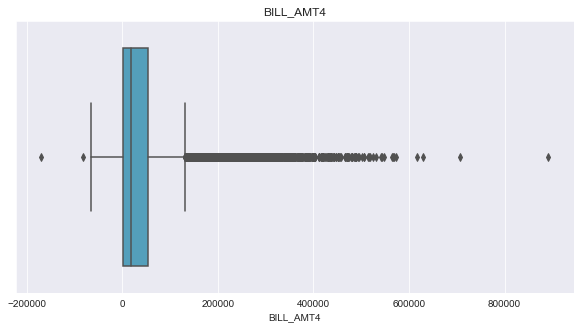

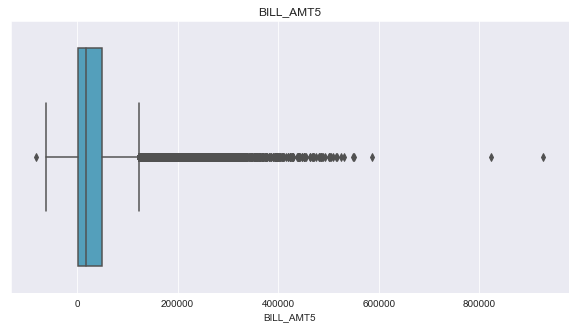

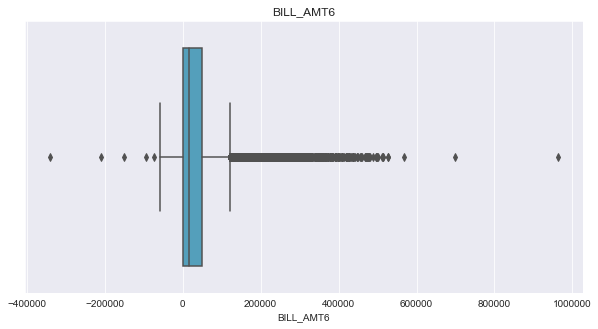

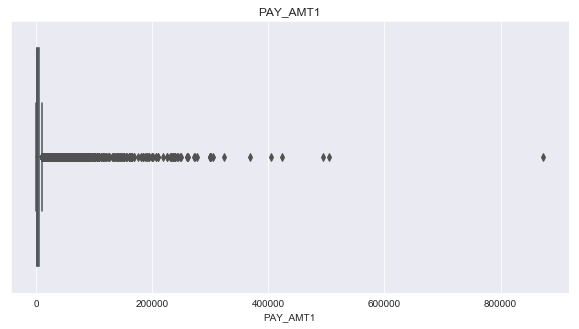

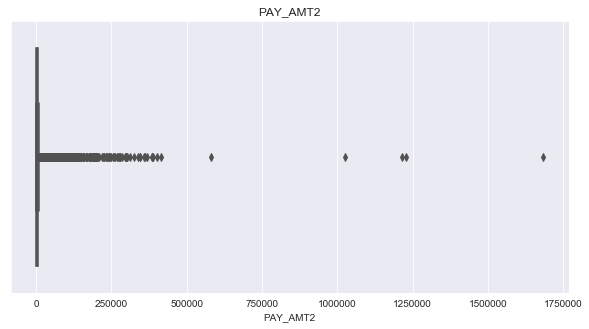

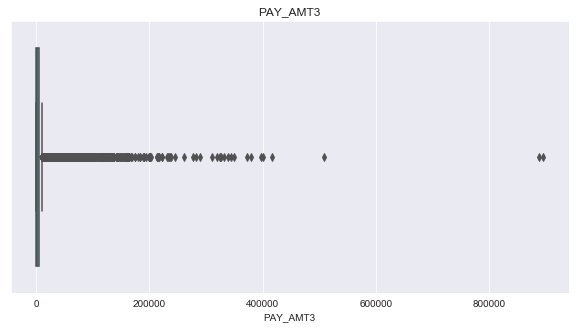

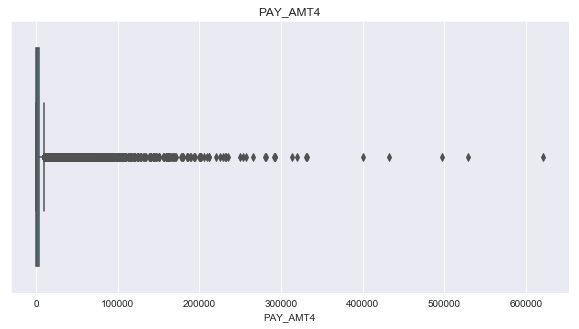

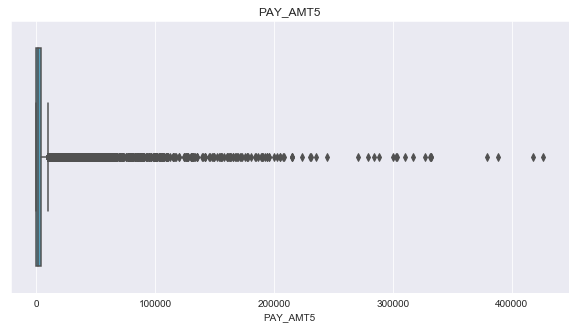

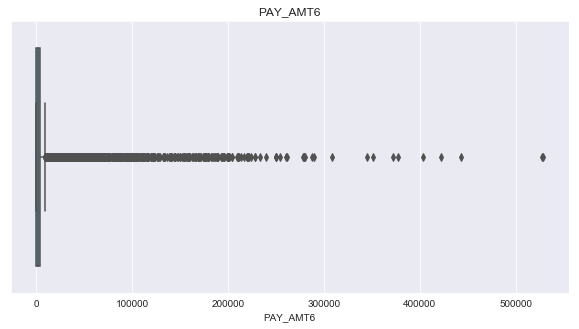

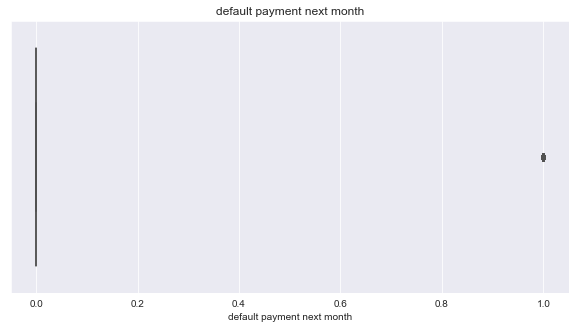

In [74]:
sns.set_style('darkgrid')
for column in df.columns:
    if column != "SEX":
        sns.boxplot(x = column, palette= 'GnBu_d', data = df).set_title(column)
        plt.show()
# plots show there is a lot of variance for certain variables particularly bill and pay amounts. This won't matter for decision trees, but some transformations will need to be done for KNN and LogReg

In [42]:
df.describe()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,167550.544914,1.815479,1.555454,35.464072,50957.432012,48942.189554,4.680320e+04,43122.554204,40235.545184,38858.449816,5649.560319,5.894788e+03,5198.415898,4828.659268,4795.032735,5181.326374,0.223134
std,129944.020953,0.710399,0.518092,9.213243,73370.242404,70923.985151,6.912389e+04,64196.383913,60699.344884,59519.893043,16568.264941,2.308919e+04,17580.914806,15711.057992,15244.217154,17657.260739,0.416355
min,10000.000000,1.000000,1.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,28.000000,3528.000000,2970.000000,2.652000e+03,2329.000000,1780.000000,1278.000000,1000.000000,8.250000e+02,390.000000,298.000000,259.000000,138.000000,0.000000
50%,140000.000000,2.000000,2.000000,34.000000,22259.000000,21050.000000,2.003500e+04,19005.000000,18091.000000,17118.000000,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,41.000000,66623.000000,63497.000000,5.983000e+04,54271.000000,50072.000000,49121.000000,5005.000000,5.000000e+03,4500.000000,4014.000000,4042.000000,4000.000000,0.000000
max,1000000.000000,4.000000,3.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [145]:
df.columns = df.columns.str.replace(' ', '_')

In [50]:
df[df.BILL_AMT2 <0]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
26,60000,Female,1,2,27,-109,-425,259,-57,127,-189,0,1000,0,500,0,1000,1
35,160000,Female,1,2,30,30265,-131,-527,-923,-1488,-1884,131,396,396,565,792,0,0
68,130000,Female,3,2,29,-190,-9850,-9850,10311,10161,7319,0,0,20161,0,7319,13899,0
101,380000,Female,1,2,30,-81,-303,32475,32891,33564,34056,223,33178,1171,1197,1250,5000,0
109,360000,Female,2,1,35,-103,-103,-103,-103,-103,-103,0,0,0,0,0,0,0
149,260000,Female,1,1,60,-1100,-1100,21400,0,969,869,0,22500,0,969,1000,0,0
173,50000,Female,1,2,24,-709,-709,-709,-2898,-3272,-3272,0,0,0,0,0,0,1
216,240000,Female,2,1,36,-946,-946,-946,-946,-946,-946,0,0,0,0,0,0,1
319,180000,Female,2,2,29,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0
345,160000,Female,1,2,29,3097,-707,-2697,2303,6182,1654,0,0,5000,5000,1500,13000,0


In [76]:
df.corr()>np.abs(.75)
# only items that are multicolinear and could present a problem are bill amounts

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,,,,,,,,,,,,,,,,,
LIMIT_BAL,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
EDUCATION,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
MARRIAGE,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AGE,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
BILL_AMT1,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT2,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT3,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT4,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False
BILL_AMT5,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False


In [51]:
df.AGE.value_counts()

29    1593
27    1455
28    1397
30    1382
26    1245
31    1205
25    1176
34    1147
32    1143
33    1127
24    1117
35    1098
36    1094
37    1023
39     941
38     936
23     917
40     850
41     811
42     786
44     691
43     666
45     600
46     557
22     553
47     492
48     457
49     444
50     402
51     333
53     317
52     299
54     242
55     207
56     175
58     122
57     120
59      82
60      66
21      64
61      56
62      44
63      31
64      30
65      24
66      23
67      16
69      15
70      10
68       5
73       4
71       3
72       3
75       3
74       1
79       1
Name: AGE, dtype: int64

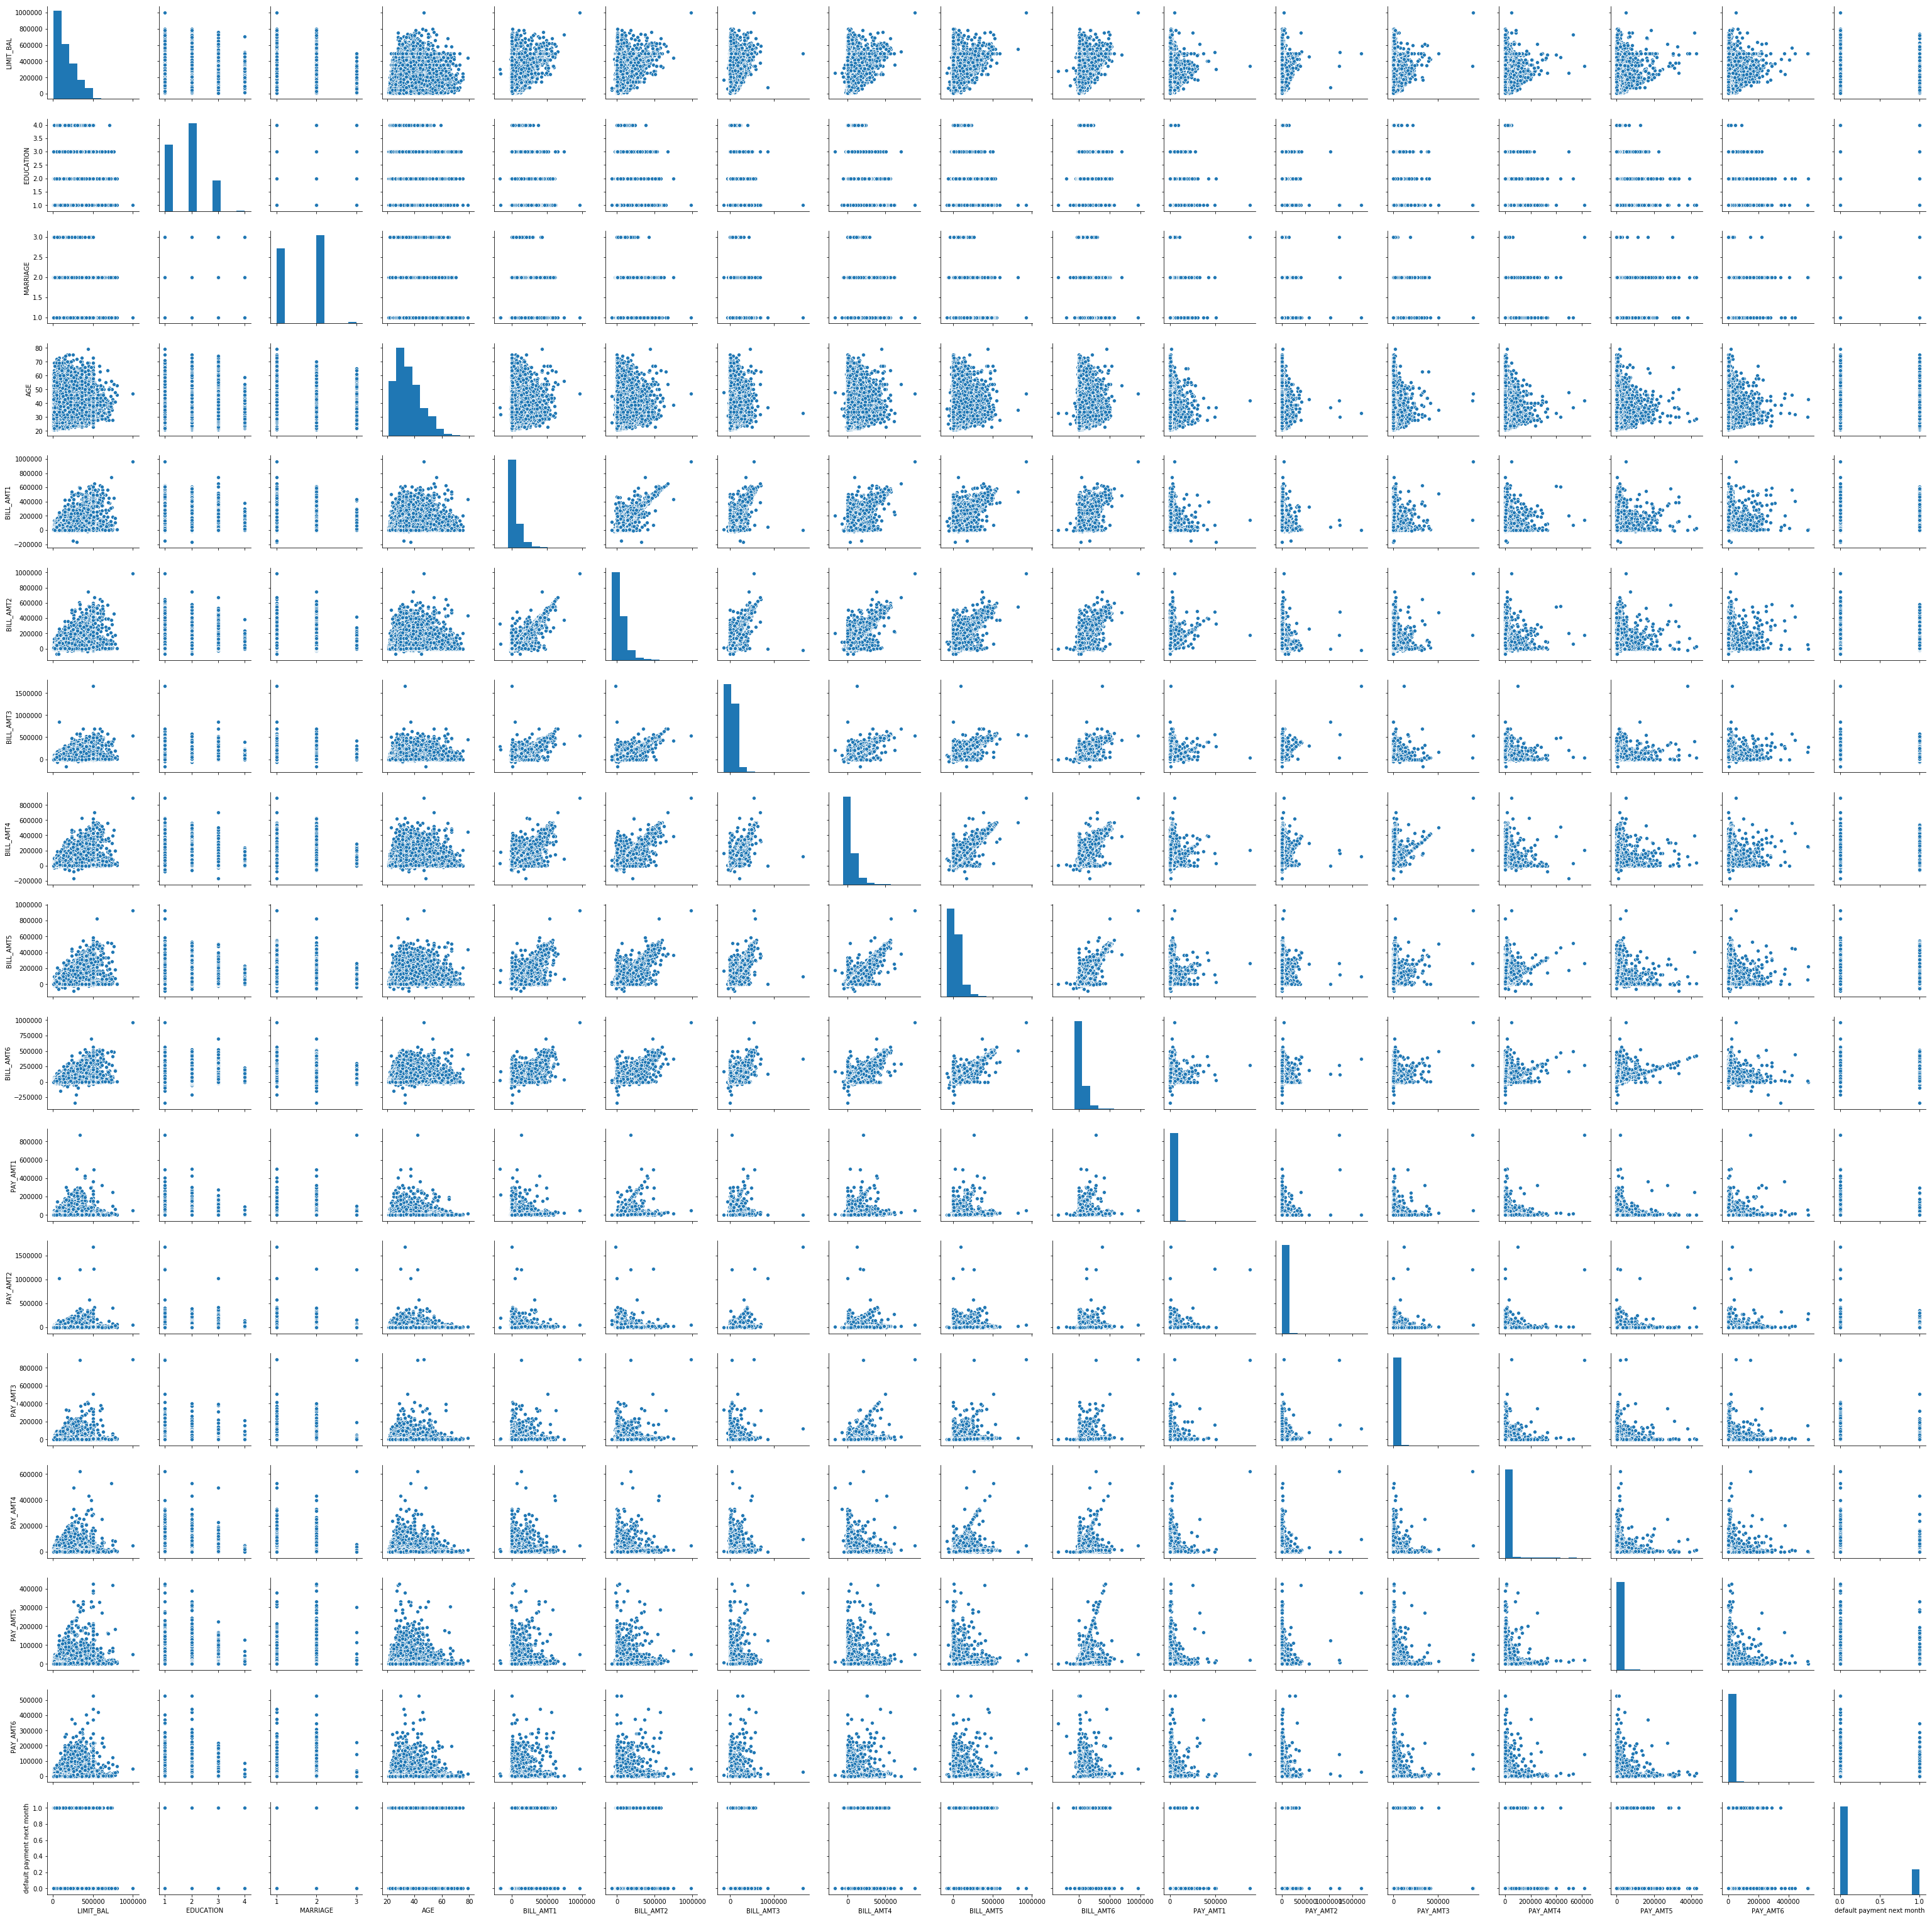

In [54]:
sns.pairplot(df)

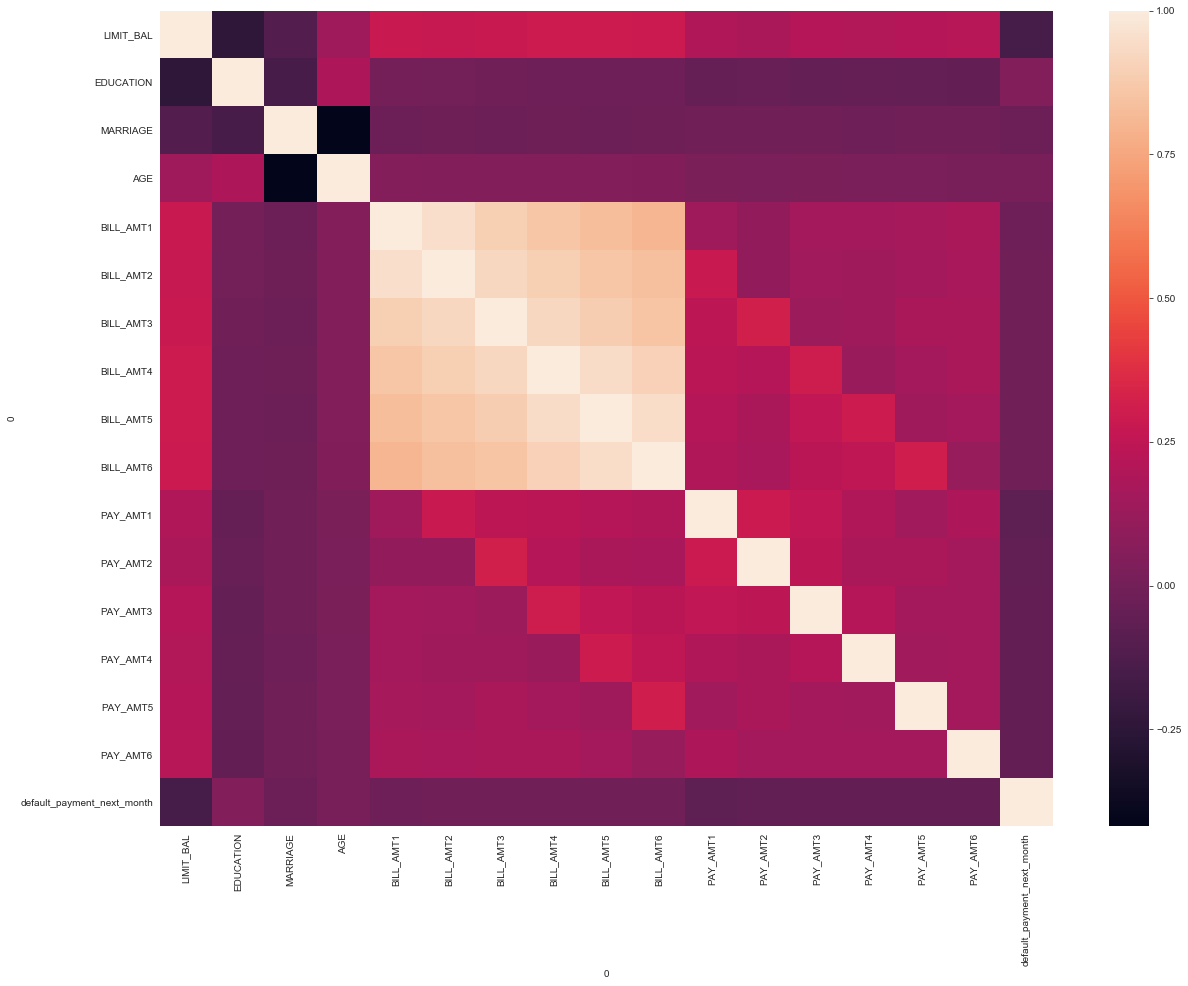

In [77]:
plt.figure(figsize = (20, 15))
sns.heatmap(df.corr())
plt.show()

Target Variable
default_payment_next_month
0    22996
1     6605
Name: default_payment_next_month, dtype: int64


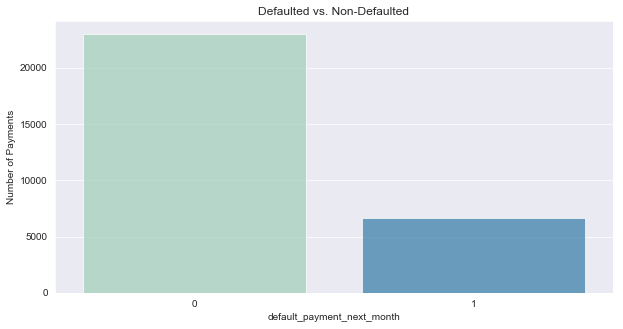

In [78]:
# Default Count. Where 0 = No and 1 = Yes
print('Target Variable')
print(df.groupby(["default_payment_next_month"]).default_payment_next_month.count())

# Target Variable Countplot
sns.set_style("darkgrid")
plt.figure(figsize = (10, 5))
sns.countplot(df["default_payment_next_month"], alpha = .70, palette = "YlGnBu")
plt.title("Defaulted vs. Non-Defaulted")
plt.ylabel("Number of Payments")
plt.show()

In [79]:
df.SEX.value_counts()

Female    17855
Male      11746
Name: SEX, dtype: int64

Defaults by gender


default_payment_next_month      0     1
SEX                                    
Female                      14111  3744
Male                         8885  2861


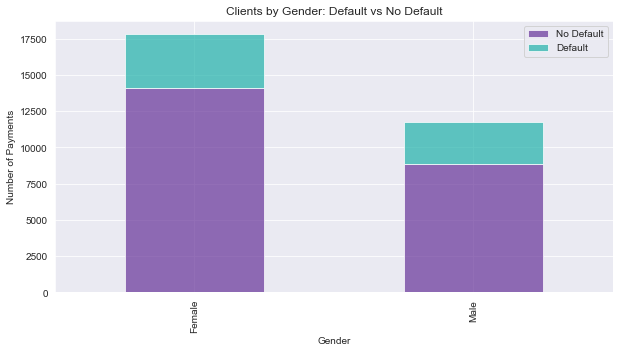

In [80]:
print("Defaults by gender")

print('\n')
print(df.groupby(["SEX","default_payment_next_month"]).SEX.count().unstack())

# Client gender visualization
gender = df.groupby(["SEX","default_payment_next_month"]).SEX.count().unstack()
p1 = gender.plot(kind = "bar", stacked = True, 
                   title = "Clients by Gender: Default vs No Default", 
                   color = ["rebeccapurple", "lightseagreen"], alpha = .70)
p1.set_xlabel("Gender")
p1.set_ylabel("Number of Payments")
p1.legend(["No Default","Default"])
plt.show()

Defaults by education level


default_payment_next_month      0     1
EDUCATION                              
1                            8545  2036
2                           10695  3329
3                            3640  1233
4                             116     7


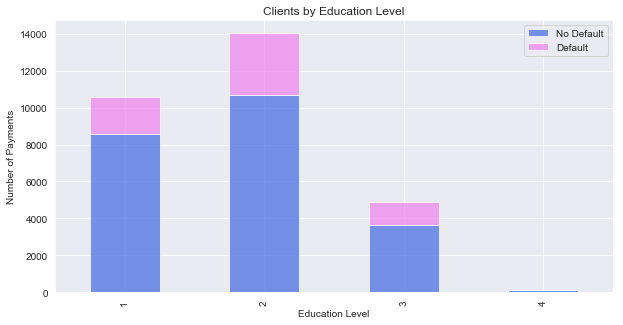

In [81]:
# Defaults by education level
print("Defaults by education level")

print("\n")
print(df.groupby(["EDUCATION", "default_payment_next_month"]).EDUCATION.count().unstack())

#Client education visualization, where 1 = graduate school; 2 = university; 3 = high school; 4 = others.
education = df.groupby(["EDUCATION", "default_payment_next_month"]).EDUCATION.count().unstack()
pl2 = education.plot(kind = "bar", stacked = True,
                    title = "Clients by Education Level", 
                    color = ["royalblue", "violet"], alpha = .70)
pl2.set_xlabel("Education Level")
pl2.set_ylabel("Number of Payments")
pl2.legend(["No Default", "Default"])
plt.show()

Defaults by civil status


default_payment_next_month      0     1
MARRIAGE                               
1                           10285  3192
2                           12477  3329
3                             234    84


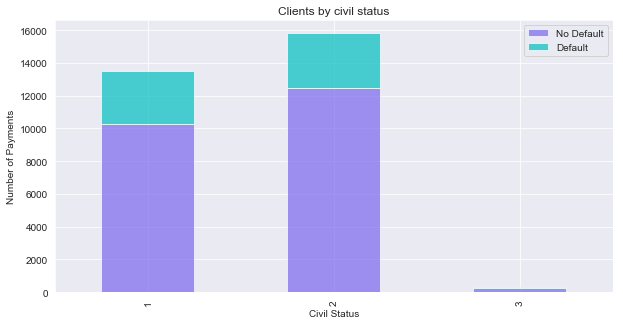

In [82]:
# Defaults by civil status
print("Defaults by civil status")

print("\n")
print(df.groupby(["MARRIAGE", "default_payment_next_month"]).MARRIAGE.count().unstack())

#Client education visualization, where 1 = married; 2 = single; 3 = others.
education = df.groupby(["MARRIAGE", "default_payment_next_month"]).MARRIAGE.count().unstack()
pl2 = education.plot(kind = "bar", stacked = True,
                    title = "Clients by civil status", 
                    color = ["mediumslateblue", "c"], alpha = .70)
pl2.set_xlabel("Civil Status")
pl2.set_ylabel("Number of Payments")
pl2.legend(["No Default", "Default"])
plt.show()

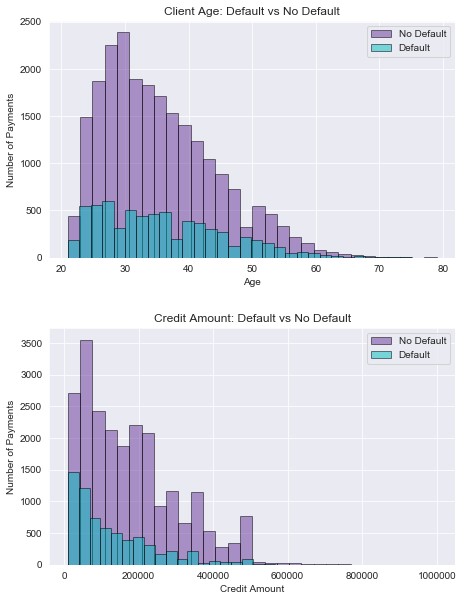

In [83]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df["default_payment_next_month"] == 0].AGE, bins = 30, label = "No Default", alpha = .50,edgecolor= "black", color = "rebeccapurple")
ax1.hist(df[df["default_payment_next_month"] == 1].AGE, bins = 30, label = "Default", alpha = .50, edgecolor = "black", color = "c")
ax1.set_title("Client Age: Default vs No Default")
ax1.set_xlabel("Age")
ax1.set_ylabel("Number of Payments")
ax1.legend(loc = "upper right")

ax2 = fig.add_subplot(223)
ax2.hist(df[df["default_payment_next_month"] == 0].LIMIT_BAL, bins = 30, label = "No Default", alpha = .50, edgecolor = "black", color = "rebeccapurple")
ax2.hist(df[df["default_payment_next_month"]==1].LIMIT_BAL, bins = 25, label = "Default", alpha = .50, edgecolor = "black", color = "c")
ax2.set_title("Credit Amount: Default vs No Default")
ax2.set_xlabel("Credit Amount")
ax2.set_ylabel("Number of Payments")
ax2.legend(loc = "upper right")


plt.show()

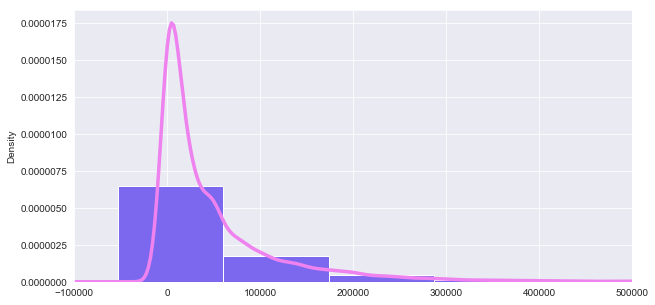

In [84]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT1"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT1"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 500000)
plt.show()

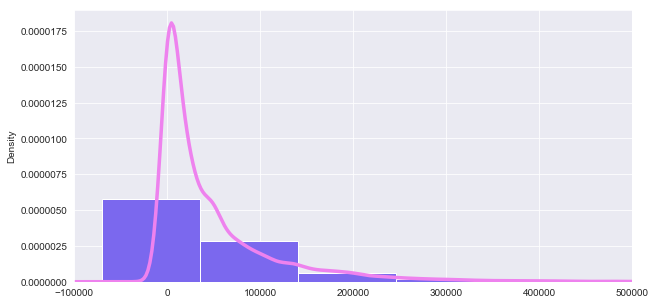

In [85]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT2"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT2"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 500000)
plt.show()

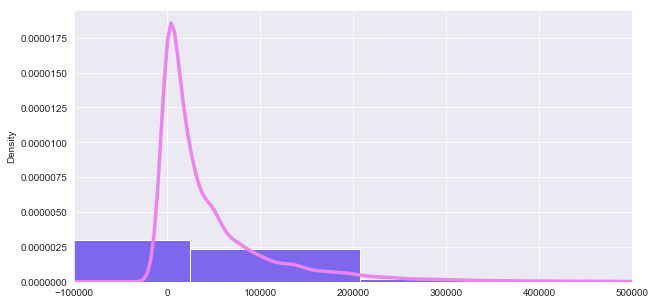

In [86]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT3"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT3"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 500000)
plt.show()

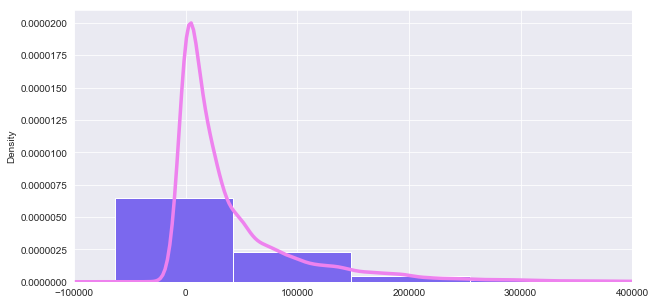

In [87]:
df["BILL_AMT4"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT4"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 400000)
plt.show()

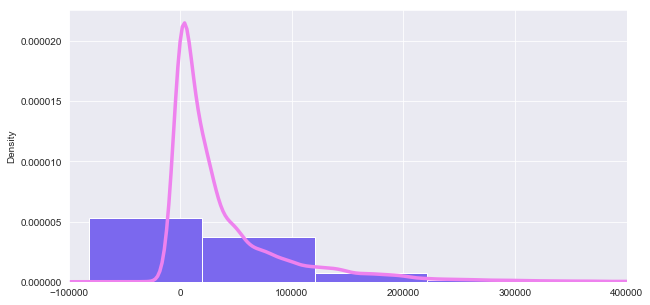

In [88]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT5"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT5"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 400000)
plt.show()

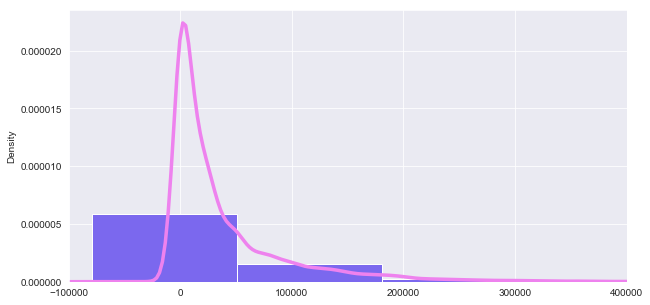

In [89]:
# Plot a histogram with a density plot for each variable in df
df["BILL_AMT6"].plot.hist(normed = True, color = "mediumslateblue")
df["BILL_AMT6"].plot.kde(linewidth = 3.5, color = "violet")
plt.xlim(-100000, 400000)
plt.show()

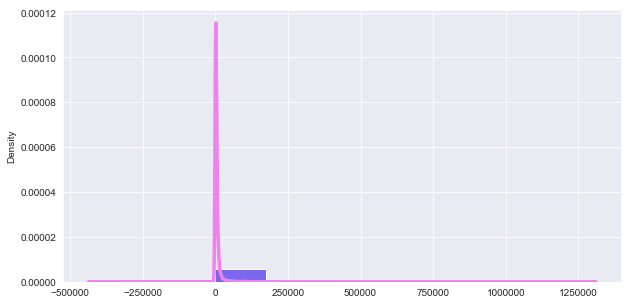

In [90]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT1"].plot.hist(normed = True, color = "mediumslateblue", bins = 5)
df["PAY_AMT1"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

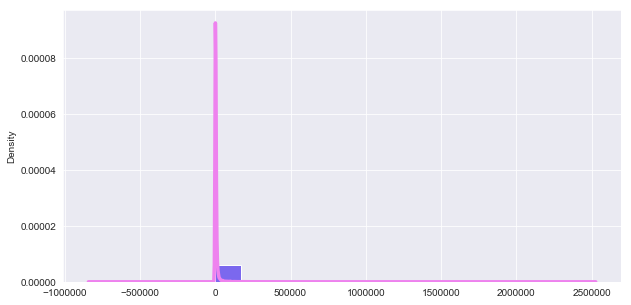

In [91]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT2"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT2"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

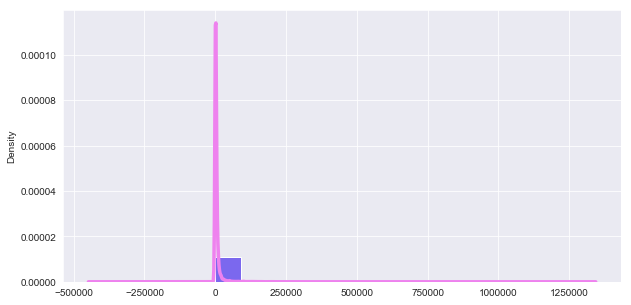

In [92]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT3"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT3"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

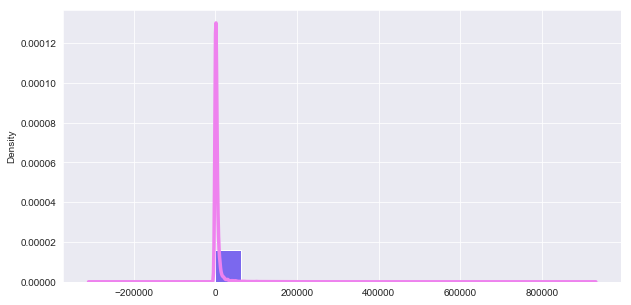

In [93]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT4"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT4"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

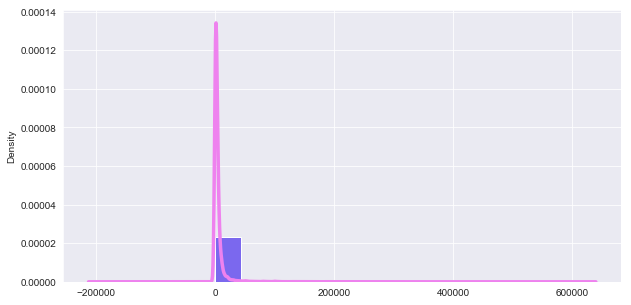

In [94]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT5"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT5"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

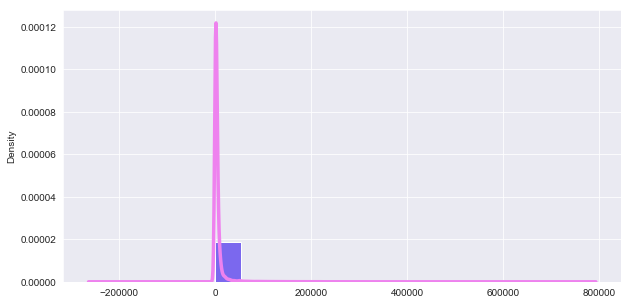

In [95]:
# Plot a histogram with a density plot for each variable in df
df["PAY_AMT6"].plot.hist(normed = True, color = "mediumslateblue")
df["PAY_AMT6"].plot.kde(linewidth = 3.5, color = "violet")
plt.show()

In [146]:
df = df[df.AGE < 71]
df = df[df.LIMIT_BAL < 750000]
df.shape

(29576, 18)

## 3. Feature Engineering

In [ ]:
# ideas
# classifying whether an item is above or below the median/average bill and pay amount
# dummy variables for all categorical features
# classifying outliers for all continuous variables?
# group by age? separate by decade or other amount?

In [96]:
df[df.columns[:-1]]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,Female,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,Female,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,Female,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,Female,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,Male,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
5,50000,Male,1,2,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800
6,500000,Male,1,2,29,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770
7,100000,Female,2,2,23,11876,380,601,221,-159,567,380,601,0,581,1687,1542
8,140000,Female,3,1,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000
9,20000,Male,3,2,35,0,0,0,0,13007,13912,0,0,0,13007,1122,0


In [101]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month'],
      dtype='object', name=0)

In [147]:
sex_dummies = pd.get_dummies(df.SEX, prefix='SEX')
ed_dummies = pd.get_dummies(df.EDUCATION, prefix='EDUCATION')
mar_dummies = pd.get_dummies(df.MARRIAGE, prefix='MARRIAGE')
df = pd.concat([df, sex_dummies, ed_dummies, mar_dummies], axis=1)
df=df.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
df.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month',
       'SEX_Female', 'SEX_Male', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

In [148]:
df.shape

(29576, 24)

In [149]:
# creating interactions only. don't think squaring any features is necessary based on pairplots
X=df.loc[:,df.columns != 'default_payment_next_month']
y = df.default_payment_next_month
from sklearn.preprocessing import PolynomialFeatures
pn=PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
pn.fit(X)
columns=pn.get_feature_names(X.columns)
poly_X=pd.DataFrame(pn.transform(X), columns=columns)
poly_X.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,EDUCATION_3 EDUCATION_4,EDUCATION_3 MARRIAGE_1,EDUCATION_3 MARRIAGE_2,EDUCATION_3 MARRIAGE_3,EDUCATION_4 MARRIAGE_1,EDUCATION_4 MARRIAGE_2,EDUCATION_4 MARRIAGE_3,MARRIAGE_1 MARRIAGE_2,MARRIAGE_1 MARRIAGE_3,MARRIAGE_2 MARRIAGE_3
0,20000.0,24.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120000.0,26.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90000.0,34.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50000.0,37.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50000.0,57.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
poly_X['PAY_1'] = np.where(poly_X.PAY_AMT1>0,1,0)
poly_X['PAY_2'] = np.where(poly_X.PAY_AMT2>0,1,0)
poly_X['PAY_3'] = np.where(poly_X.PAY_AMT3>0,1,0)
poly_X['PAY_4'] = np.where(poly_X.PAY_AMT4>0,1,0)
poly_X['PAY_5'] = np.where(poly_X.PAY_AMT5>0,1,0)
poly_X['PAY_6'] = np.where(poly_X.PAY_AMT6>0,1,0)

In [163]:
poly_X['PAY_RATIO_1'] = np.where(poly_X.BILL_AMT1 != 0, round((poly_X.PAY_AMT1/poly_X.BILL_AMT1),2),0)
poly_X['PAY_RATIO_2'] = np.where(poly_X.BILL_AMT2 != 0, round((poly_X.PAY_AMT2/poly_X.BILL_AMT2),2),0)
poly_X['PAY_RATIO_3'] = np.where(poly_X.BILL_AMT3 != 0, round((poly_X.PAY_AMT3/poly_X.BILL_AMT3),2),0)
poly_X['PAY_RATIO_4'] = np.where(poly_X.BILL_AMT4 != 0, round((poly_X.PAY_AMT4/poly_X.BILL_AMT4),2),0)
poly_X['PAY_RATIO_5'] = np.where(poly_X.BILL_AMT5 != 0, round((poly_X.PAY_AMT5/poly_X.BILL_AMT5),2),0)
poly_X['PAY_RATIO_6'] = np.where(poly_X.BILL_AMT6 != 0, round((poly_X.PAY_AMT6/poly_X.BILL_AMT6),2),0)

In [164]:
# checking for null values based on 
poly_X.isnull().sum().sum()

0

In [167]:
poly_X.to_csv('engineered_features.csv')
y.to_csv('target_variable.csv')

In [165]:
# solving for class imbalance in target variable
from imblearn.over_sampling import SMOTE

X_resample, y_resample = SMOTE().fit_sample(poly_X,y)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_resample,y_resample,random_state=40,test_size=.2)

In [124]:
scale=MinMaxScaler(feature_range=(0,1))
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [126]:
x_check = pd.DataFrame(X_train, columns=X.columns)
x_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36761 entries, 0 to 36760
Data columns (total 41 columns):
LIMIT_BAL      36761 non-null float64
AGE            36761 non-null float64
BILL_AMT1      36761 non-null float64
BILL_AMT2      36761 non-null float64
BILL_AMT3      36761 non-null float64
BILL_AMT4      36761 non-null float64
BILL_AMT5      36761 non-null float64
BILL_AMT6      36761 non-null float64
PAY_AMT1       36761 non-null float64
PAY_AMT2       36761 non-null float64
PAY_AMT3       36761 non-null float64
PAY_AMT4       36761 non-null float64
PAY_AMT5       36761 non-null float64
PAY_AMT6       36761 non-null float64
SEX_Female     36761 non-null float64
SEX_Male       36761 non-null float64
EDUCATION_1    36761 non-null float64
EDUCATION_2    36761 non-null float64
EDUCATION_3    36761 non-null float64
EDUCATION_4    36761 non-null float64
MARRIAGE_1     36761 non-null float64
MARRIAGE_2     36761 non-null float64
MARRIAGE_3     36761 non-null float64
SEX_Female     36

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## 6. Model Evaluation

## 7. Final Model

## 8. Document in the markdown cells below how you did paired programming.

### How we did paired programming:
- !!!

Additional details on paired programming: